# IMPORTS AND SETUP

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# DATA PREPARATION


In [10]:
def load_dataset():
    """Load the wells dataset from CSV file"""
    wells_df = pd.read_csv("spe_africa_dseats_datathon_2025_wells_dataset.csv")
    return wells_df

def initial_data_inspection(wells_df):
    """Perform initial inspection of the dataset"""
    print("=" * 60)
    print("INITIAL DATA INSPECTION")
    print("=" * 60)
    print("Original dataset shape:", wells_df.shape)
    print("\nColumn names:", wells_df.columns.tolist())
    print("\nFirst few rows:")
    wells_df_table = wells_df.head()
    print(tabulate(wells_df_table, headers='keys', tablefmt='fancy_grid'))
    print("\nData types:")
    print(wells_df.dtypes)
    print("\nMissing values:")
    print(wells_df.isnull().sum())
    return wells_df

# Load and inspect data
wells_df = load_dataset()
wells_df = initial_data_inspection(wells_df)

INITIAL DATA INSPECTION
Original dataset shape: (7955, 13)

Column names: ['PROD_DATE', 'WELL_NAME', 'ON_STREAM_HRS', 'BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'DOWNHOLE_TEMPERATURE (deg F)', 'ANNULUS_PRESS (PSI)', 'CHOKE_SIZE (%)', 'WELL_HEAD_PRESSURE (PSI)', 'WELL_HEAD_TEMPERATURE (deg F)', 'CUMULATIVE_OIL_PROD (STB)', 'CUMULATIVE_FORMATION_GAS_PROD (MSCF)', 'CUMULATIVE_TOTAL_GAS_PROD (MSCF)', 'CUMULATIVE_WATER_PROD (BBL)']

First few rows:
╒════╤═════════════╤═════════════╤═════════════════╤═════════════════════════════════════╤════════════════════════════════╤═══════════════════════╤══════════════════╤════════════════════════════╤═════════════════════════════════╤═════════════════════════════╤════════════════════════════════════════╤════════════════════════════════════╤═══════════════════════════════╕
│    │ PROD_DATE   │ WELL_NAME   │   ON_STREAM_HRS │ BOTTOMHOLE_FLOWING_PRESSURE (PSI)   │   DOWNHOLE_TEMPERATURE (deg F) │   ANNULUS_PRESS (PSI) │   CHOKE_SIZE (%) │   WELL_HEAD_PRESSURE 

# EXPLORATORY DATA ANALYSIS (EDA)


In [11]:
def perform_eda(wells_df):
    """Perform exploratory data analysis"""
    print("\n" + "=" * 60)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 60)
    
    # Basic statistics
    print("\nBasic Statistics:")
    stats = wells_df.describe()
    print(tabulate(stats, headers='keys', tablefmt='fancy_grid'))
    
    # Unique wells
    unique_wells = wells_df['WELL_NAME'].unique()
    print(f"\nNumber of unique wells: {len(unique_wells)}")
    print(f"Well names: {sorted(unique_wells, key=lambda x: int(x.split('#')[1]))}")
    
    # Date range analysis
    print(f"\nDate range in dataset:")
    print(f"From: {wells_df['PROD_DATE'].min()}")
    print(f"To: {wells_df['PROD_DATE'].max()}")
    
    # Records per well
    records_per_well = wells_df.groupby('WELL_NAME').size()
    print(f"\nRecords per well:")
    print(f"Min: {records_per_well.min()}")
    print(f"Max: {records_per_well.max()}")
    print(f"Average: {records_per_well.mean():.1f}")
    
    # Production statistics
    print("\nProduction Overview:")
    print(f"Total cumulative oil production columns: {[col for col in wells_df.columns if 'CUMULATIVE_OIL' in col]}")
    print(f"On-stream hours column: {[col for col in wells_df.columns if 'ON_STREAM' in col]}")
    
    return wells_df

# Perform EDA
wells_df = perform_eda(wells_df)



EXPLORATORY DATA ANALYSIS

Basic Statistics:
╒═══════╤═════════════════╤════════════════════════════════╤══════════════════╤═════════════════════════════════╕
│       │   ON_STREAM_HRS │   DOWNHOLE_TEMPERATURE (deg F) │   CHOKE_SIZE (%) │   WELL_HEAD_TEMPERATURE (deg F) │
╞═══════╪═════════════════╪════════════════════════════════╪══════════════════╪═════════════════════════════════╡
│ count │      7955       │                      7955      │        7955      │                       7955      │
├───────┼─────────────────┼────────────────────────────────┼──────────────────┼─────────────────────────────────┤
│ mean  │        21.6235  │                       168.757  │          56.1553 │                         86.8364 │
├───────┼─────────────────┼────────────────────────────────┼──────────────────┼─────────────────────────────────┤
│ std   │         6.56783 │                        31.9178 │          34.9754 │                         22.7386 │
├───────┼─────────────────┼───────────────

# DATA PREPROCESSING


In [12]:
def preprocess_data(wells_df):
    """Clean and preprocess the raw data"""
    print("\n" + "=" * 60)
    print("DATA PREPROCESSING")
    print("=" * 60)
    
    # Convert PROD_DATE to datetime
    print("Converting PROD_DATE to datetime...")
    wells_df['PROD_DATE'] = pd.to_datetime(wells_df['PROD_DATE'], format='%d-%b-%y', errors='coerce')
    
    # Convert numerical columns
    print("Converting numerical columns...")
    cols_to_convert = [col for col in wells_df.columns if col not in ["PROD_DATE", "WELL_NAME"]]
    wells_df[cols_to_convert] = wells_df[cols_to_convert].replace(",", "", regex=True).apply(pd.to_numeric, errors="coerce")
    
    # Sort data by well name and production date
    print("Sorting data by well name and production date...")
    wells_df = wells_df.sort_values(['WELL_NAME', 'PROD_DATE']).reset_index(drop=True)
    # Fix cumulative production anomalies (ensure non-decreasing)
    print("Fixing cumulative production anomalies...")

    anomaly_wells = []

    for well_name, group in wells_df.groupby("WELL_NAME"):
        if (group["CUMULATIVE_OIL_PROD (STB)"].diff().dropna() < 0).any():
            anomaly_wells.append(well_name)

    if anomaly_wells:
        print(f"\nWells with anomalies (drop in cumulative production):")
        for well in anomaly_wells:
            print(f"- {well}")
    else:
        print("No anomalies detected in cumulative production.")

    # Fix cumulative production anomalies (ensure non-decreasing)
    print("Fixing cumulative production anomalies...")
    wells_df["CUMULATIVE_OIL_PROD (STB)"] = wells_df.groupby("WELL_NAME")["CUMULATIVE_OIL_PROD (STB)"].transform("cummax")
    
    print("Data preprocessing completed!")
    print(f"Final dataset shape: {wells_df.shape}")
    print(f"Date range after preprocessing: {wells_df['PROD_DATE'].min()} to {wells_df['PROD_DATE'].max()}")
    
    return wells_df

# Preprocess data
wells_df = preprocess_data(wells_df)
wells_df.head()
wells_df.to_csv("d-procvessed.csv", index=False)



DATA PREPROCESSING
Converting PROD_DATE to datetime...
Converting numerical columns...
Sorting data by well name and production date...
Fixing cumulative production anomalies...

Wells with anomalies (drop in cumulative production):
- Well_#6
Fixing cumulative production anomalies...
Data preprocessing completed!
Final dataset shape: (7955, 13)
Date range after preprocessing: 2011-02-17 00:00:00 to 2016-08-12 00:00:00


# FEATURE ENGINEERING


In [14]:
def engineer_features(wells_df):
    """Create new features for classification"""
    print("\n" + "=" * 60)
    print("FEATURE ENGINEERING")
    print("=" * 60)
    
    # Calculate daily oil production from cumulative data
    print("Calculating daily oil production rates...")
    wells_df["DAILY_OIL_PROD (STB/day)"] = wells_df.groupby("WELL_NAME")["CUMULATIVE_OIL_PROD (STB)"].diff().fillna(0)
    print(tabulate(wells_df.head(), headers='keys', tablefmt='fancy_grid'))

    # Create producing status indicator
    print("Creating production status indicators...")
    wells_df["IS_PRODUCING"] = wells_df["ON_STREAM_HRS"] > 0
    
    # Set production to 0 for non-producing days
    wells_df.loc[~wells_df["IS_PRODUCING"], "DAILY_OIL_PROD (STB/day)"] = 0
    
    # Create additional time-based features
    print("Creating time-based features...")
    wells_df['YEAR'] = wells_df['PROD_DATE'].dt.year
    wells_df['MONTH'] = wells_df['PROD_DATE'].dt.month
    wells_df['DAY_OF_YEAR'] = wells_df['PROD_DATE'].dt.dayofyear
    
    # Calculate production statistics per well
    print("Calculating production statistics per well...")
    well_stats = wells_df.groupby('WELL_NAME').agg({
        'DAILY_OIL_PROD (STB/day)': ['mean', 'max', 'min', 'std'],
        'IS_PRODUCING': 'sum',
        'PROD_DATE': 'count'
    }).round(2)
    
    well_stats.columns = ['_'.join(col).strip() for col in well_stats.columns.values]
    print("\nProduction statistics per well:")
    stats = well_stats.head(20)
    print(tabulate(stats, headers='keys', tablefmt='fancy_grid'))
    
    print("Feature engineering completed!")
    print(f"Total features: {len(wells_df.columns)}")
    print(f"New features created: DAILY_OIL_PROD, IS_PRODUCING, YEAR, MONTH, DAY_OF_YEAR")
    
    return wells_df

# Engineer features
wells_df = engineer_features(wells_df)


FEATURE ENGINEERING
Calculating daily oil production rates...
╒════╤═════════════════════╤═════════════╤═════════════════╤═════════════════════════════════════╤════════════════════════════════╤═══════════════════════╤══════════════════╤════════════════════════════╤═════════════════════════════════╤═════════════════════════════╤════════════════════════════════════════╤════════════════════════════════════╤═══════════════════════════════╤════════════════════════════╤════════════════╤════════╤═════════╤═══════════════╕
│    │ PROD_DATE           │ WELL_NAME   │   ON_STREAM_HRS │   BOTTOMHOLE_FLOWING_PRESSURE (PSI) │   DOWNHOLE_TEMPERATURE (deg F) │   ANNULUS_PRESS (PSI) │   CHOKE_SIZE (%) │   WELL_HEAD_PRESSURE (PSI) │   WELL_HEAD_TEMPERATURE (deg F) │   CUMULATIVE_OIL_PROD (STB) │   CUMULATIVE_FORMATION_GAS_PROD (MSCF) │   CUMULATIVE_TOTAL_GAS_PROD (MSCF) │   CUMULATIVE_WATER_PROD (BBL) │   DAILY_OIL_PROD (STB/day) │ IS_PRODUCING   │   YEAR │   MONTH │   DAY_OF_YEAR │
╞════╪═════════════

# CLASSIFICATION


In [ ]:
def classify_well_production_type(well_data, well_name):
    """
    Classify a well as Steady or Unsteady based on production drops
    
    Unsteady Definition: Wells with >50% drop in oil production at least once every 3-6 months
    """
    # Sort by production date
    well_data = well_data.sort_values('PROD_DATE').reset_index(drop=True)
    
    # Only consider producing days for baseline calculations
    producing_data = well_data[well_data['IS_PRODUCING'] == True].copy()
    
    if len(producing_data) < 30:  # Need sufficient data
        return "Steady"  # Default to steady if insufficient data
    
    # Calculate rolling averages for different windows (30, 60, 90 days)
    # This helps capture the "every 3-6 months" requirement
    windows = [30, 60, 90]  # 1-3 months windows
    
    drop_detected = False
    significant_drops = []
    
    for window in windows:
        # Calculate rolling average production
        producing_data[f'rolling_avg_{window}d'] = producing_data['DAILY_OIL_PROD (STB/day)'].rolling(
            window=window, min_periods=max(1, window//3)
        ).mean()
        
        # Calculate rolling maximum to establish baseline
        producing_data[f'rolling_max_{window}d'] = producing_data['DAILY_OIL_PROD (STB/day)'].rolling(
            window=window, min_periods=max(1, window//3)
        ).max()
        
        # Calculate percentage drop from rolling maximum
        producing_data[f'pct_drop_{window}d'] = (
            producing_data['DAILY_OIL_PROD (STB/day)'] / 
            producing_data[f'rolling_max_{window}d'].shift(1) - 1
        )
                                                                                                                                                                                       
        # Check for drops > 50%
        drops = producing_data[producing_data[f'pct_drop_{window}d'] < -0.5]
        
        if len(drops) > 0:
            significant_drops.extend(drops[['PROD_DATE', f'pct_drop_{window}d']].values.tolist())


    # Alternative method: Check for sustained drops
    # Calculate 7-day rolling average for smoothing
    producing_data['smooth_prod'] = producing_data['DAILY_OIL_PROD (STB/day)'].rolling(
        window=7, min_periods=1
    ).mean()
    
    # Look for month-over-month drops
    producing_data['month_year'] = producing_data['PROD_DATE'].dt.to_period('M')
    monthly_avg = producing_data.groupby('month_year')['smooth_prod'].mean()
    
    # Check for >50% drops between consecutive months
    monthly_drops = monthly_avg.pct_change()
    monthly_significant_drops = monthly_drops[monthly_drops < -0.5]
    
    # Check timing requirement: at least once every 3-6 months
    if len(monthly_significant_drops) > 0:
        # Get the months with significant drops
        drop_months = monthly_significant_drops.index
        
        # Check if drops occur within 3-6 month intervals
        for i in range(len(drop_months)):
            # Look ahead to see if there's another drop within 6 months
            current_month = drop_months[i]
            within_6_months = [
                m for m in drop_months[i:] 
                if (m - current_month).n <= 6
            ]
            
            if len(within_6_months) > 0:
                drop_detected = True
                break
    
    # Final classification logic
    if len(significant_drops) > 0 or len(monthly_significant_drops) > 0:
        drop_detected = True
    
    # Additional check: Overall production variance
    if len(producing_data) > 90:  # At least 3 months of data
        cv = producing_data['DAILY_OIL_PROD (STB/day)'].std() / producing_data['DAILY_OIL_PROD (STB/day)'].mean()
        if cv > 0.8:  # High coefficient of variation indicates instability
            drop_detected = True
    
    classification = "Unsteady" if drop_detected else "Steady"
    
    # Print debug information
    print(f"\n{well_name} Classification Analysis:")
    print(f"- Producing days: {len(producing_data)}")
    print(f"- Significant drops detected: {len(significant_drops)}")
    print(f"- Monthly drops: {len(monthly_significant_drops)}")
    if len(producing_data) > 0:
        print(f"- Production CV: {producing_data['DAILY_OIL_PROD (STB/day)'].std() / producing_data['DAILY_OIL_PROD (STB/day)'].mean():.3f}")
    print(f"- Classification: {classification}")
    
    return classification

def perform_classification(wells_df):
    """Apply classification to all wells"""
    print("\n" + "=" * 60)
    print("WELL CLASSIFICATION")
    print("=" * 60)
    
    # Group wells data
    wells_grouped = {well: group for well, group in wells_df.groupby("WELL_NAME")}
    
    print("Starting well classification analysis...")
    print("=" * 50)
    
    # Apply classification to all wells
    well_classifications = {}
    for well_name in sorted(wells_grouped.keys(), key=lambda x: int(x.split("#")[1])):
        well_data = wells_grouped[well_name]
        classification = classify_well_production_type(well_data, well_name)
        well_classifications[well_name] = classification
    
    return well_classifications, wells_grouped

# Perform classification
well_classifications, wells_grouped = perform_classification(wells_df)


WELL CLASSIFICATION
Starting well classification analysis...
╒════╤═════════════════════╤═════════════╤═════════════════╤═════════════════════════════════════╤════════════════════════════════╤═══════════════════════╤══════════════════╤════════════════════════════╤═════════════════════════════════╤═════════════════════════════╤════════════════════════════════════════╤════════════════════════════════════╤═══════════════════════════════╤════════════════════════════╤════════════════╤════════╤═════════╤═══════════════╕
│    │ PROD_DATE           │ WELL_NAME   │   ON_STREAM_HRS │   BOTTOMHOLE_FLOWING_PRESSURE (PSI) │   DOWNHOLE_TEMPERATURE (deg F) │   ANNULUS_PRESS (PSI) │   CHOKE_SIZE (%) │   WELL_HEAD_PRESSURE (PSI) │   WELL_HEAD_TEMPERATURE (deg F) │   CUMULATIVE_OIL_PROD (STB) │   CUMULATIVE_FORMATION_GAS_PROD (MSCF) │   CUMULATIVE_TOTAL_GAS_PROD (MSCF) │   CUMULATIVE_WATER_PROD (BBL) │   DAILY_OIL_PROD (STB/day) │ IS_PRODUCING   │   YEAR │   MONTH │   DAY_OF_YEAR │
╞════╪══════════════

# RESULTS AND VISUALIZATION



FINAL WELL CLASSIFICATIONS
Well_#1: Unsteady
Well_#2: Unsteady
Well_#3: Unsteady
Well_#4: Unsteady
Well_#5: Unsteady
Well_#6: Unsteady
Well_#7: Unsteady
Well_#8: Unsteady
Well_#9: Unsteady
Well_#10: Unsteady
Well_#11: Unsteady
Well_#12: Unsteady
Well_#13: Unsteady
Well_#14: Unsteady
Well_#15: Unsteady
Well_#16: Unsteady
Well_#17: Unsteady
Well_#18: Unsteady
Well_#19: Steady
Well_#20: Unsteady

SUMMARY:
Steady wells: 1
Unsteady wells: 19
Total wells: 20

CREATING VISUALIZATIONS


<Figure size 1200x800 with 0 Axes>

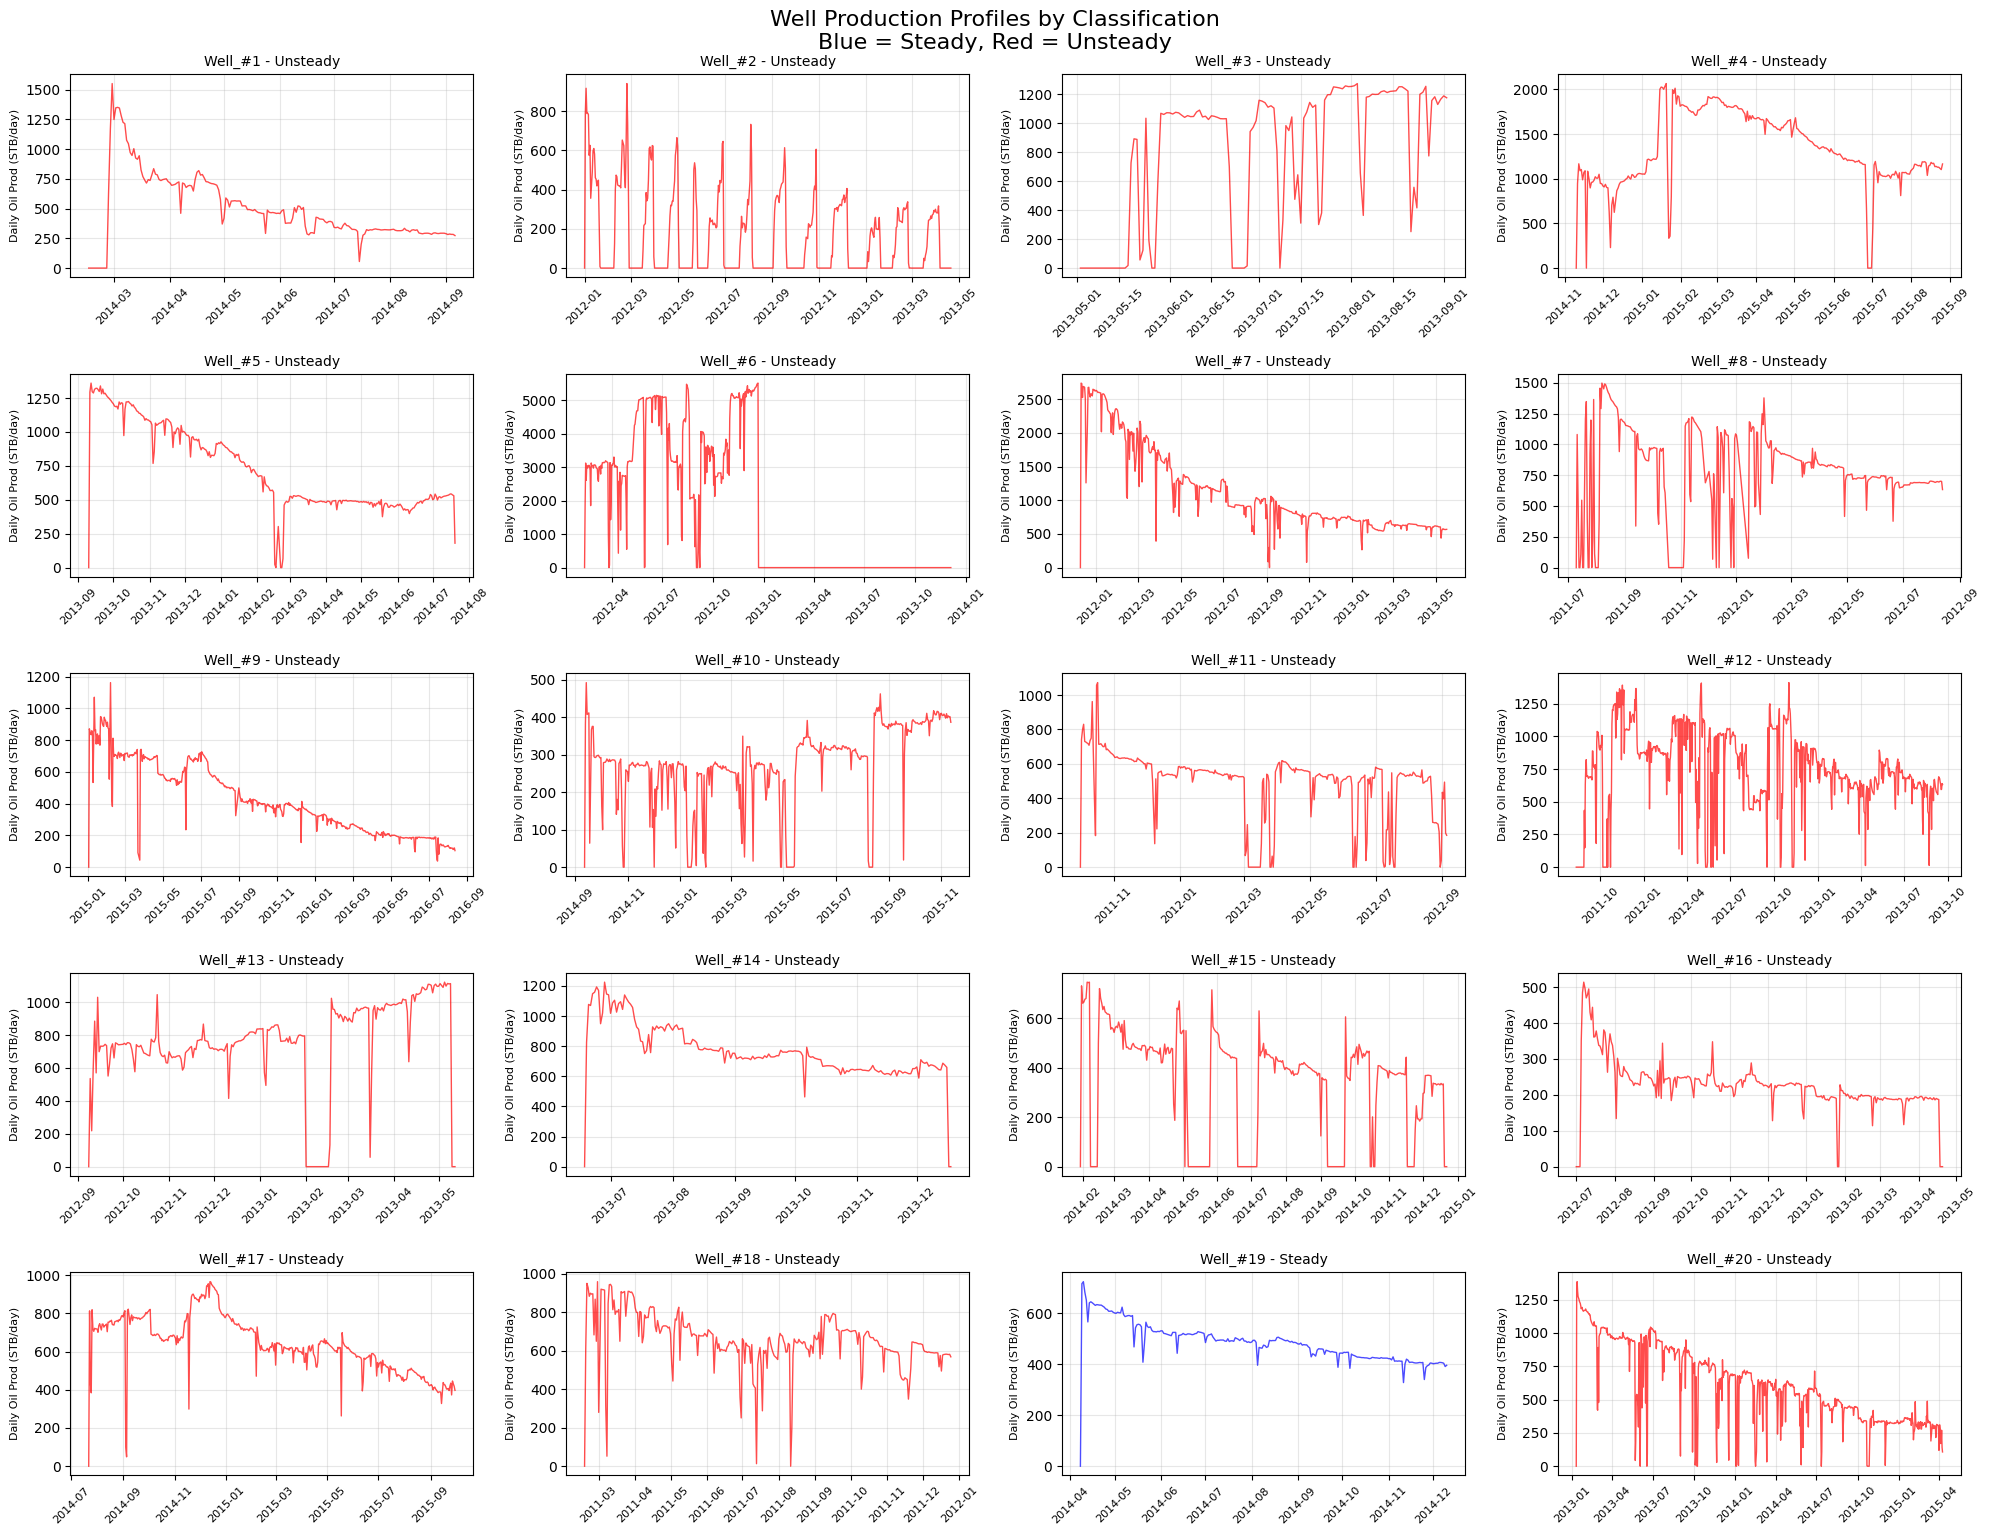


SAVING RESULTS
Classification results saved to: YourTeamName_DSEATS_Africa_2025_Classification.csv

Final Classification Results:
    Well Production Type
0      1        Unsteady
1      2        Unsteady
2      3        Unsteady
3      4        Unsteady
4      5        Unsteady
5      6        Unsteady
6      7        Unsteady
7      8        Unsteady
8      9        Unsteady
9     10        Unsteady
10    11        Unsteady
11    12        Unsteady
12    13        Unsteady
13    14        Unsteady
14    15        Unsteady
15    16        Unsteady
16    17        Unsteady
17    18        Unsteady
18    19          Steady
19    20        Unsteady

DETAILED VALIDATION ANALYSIS

Well_#1 Detailed Analysis:
- Total production days: 204
- Producing days: 193
- Average daily production: 526.73 STB/day
- Max daily production: 1550.00 STB/day
- Min daily production: 55.00 STB/day
- Months with >50% drops: 0
- Final Classification: Unsteady

Well_#10 Detailed Analysis:
- Total production days:

In [14]:
def display_results(well_classifications):
    """Display classification results and summary"""
    print("\n" + "=" * 50)
    print("FINAL WELL CLASSIFICATIONS")
    print("=" * 50)
    
    # Create summary results
    classification_summary = pd.DataFrame(
        list(well_classifications.items()), 
        columns=['WELL_NAME', 'PRODUCTION_TYPE']
    )
    
    # Sort by well number
    classification_summary['Well_Number'] = classification_summary['WELL_NAME'].str.extract('(\d+)').astype(int)
    classification_summary = classification_summary.sort_values('Well_Number').reset_index(drop=True)
    
    for idx, row in classification_summary.iterrows():
        print(f"{row['WELL_NAME']}: {row['PRODUCTION_TYPE']}")
    
    # Summary statistics
    steady_count = sum(1 for c in well_classifications.values() if c == "Steady")
    unsteady_count = sum(1 for c in well_classifications.values() if c == "Unsteady")
    
    print(f"\nSUMMARY:")
    print(f"Steady wells: {steady_count}")
    print(f"Unsteady wells: {unsteady_count}")
    print(f"Total wells: {len(well_classifications)}")
    
    return classification_summary

def create_visualizations(well_classifications, wells_grouped):
    """Create visualization of classifications"""
    print("\n" + "=" * 60)
    print("CREATING VISUALIZATIONS")
    print("=" * 60)
    
    # Create visualization of classifications
    plt.figure(figsize=(12, 8))
    
    # Plot production profiles colored by classification
    fig, axes = plt.subplots(5, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    for idx, (well_name, classification) in enumerate(sorted(well_classifications.items(), key=lambda x: int(x[0].split("#")[1]))):
        well_data = wells_grouped[well_name]
        color = 'red' if classification == 'Unsteady' else 'blue'
        
        axes[idx].plot(well_data['PROD_DATE'], well_data['DAILY_OIL_PROD (STB/day)'], 
                       color=color, alpha=0.7, linewidth=1)
        axes[idx].set_title(f"{well_name} - {classification}", fontsize=10)
        axes[idx].set_ylabel('Daily Oil Prod (STB/day)', fontsize=8)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    
    plt.tight_layout()
    plt.suptitle('Well Production Profiles by Classification\nBlue = Steady, Red = Unsteady', 
                 fontsize=16, y=1.02)
    plt.show()

def save_results(well_classifications):
    """Save classification results to CSV"""
    print("\n" + "=" * 60)
    print("SAVING RESULTS")
    print("=" * 60)
    
    # Create the final classification CSV file
    # Create the required format matching the competition requirements
    final_classification = pd.DataFrame({
        'Well': range(1, 21),
        'Reservoir Name': [''] * 20,  # Not required for this task
        'Reservoir Type': [''] * 20,  # Not required for this task
        'Well Type': [''] * 20,       # Not required for this task
        'Production Type': [''] * 20,  # This is what we need to fill
        'Formation GOR Trend': [''] * 20,  # Not required for this task
        'Watercut Trend': [''] * 20,      # Not required for this task
        'Oil Productivity Index': [''] * 20  # Not required for this task
    })
    
    # Fill in the Production Type based on our classification
    for idx, row in final_classification.iterrows():
        well_name = f"Well_#{row['Well']}"
        if well_name in well_classifications:
            final_classification.loc[idx, 'Production Type'] = well_classifications[well_name]
    
    # Save the classification results
    team_name = "YourTeamName"  # Replace with your actual team name
    output_filename = f"{team_name}_DSEATS_Africa_2025_Classification.csv"
    final_classification.to_csv(output_filename, index=False)
    
    print(f"Classification results saved to: {output_filename}")
    print("\nFinal Classification Results:")
    print(final_classification[['Well', 'Production Type']])
    
    return final_classification

def detailed_validation(well_classifications, wells_grouped):
    """Perform detailed validation analysis"""
    print("\n" + "=" * 60)
    print("DETAILED VALIDATION ANALYSIS")
    print("=" * 60)
    
    # Analyze a few representative wells in detail
    sample_wells = ['Well_#1', 'Well_#10', 'Well_#20']
    
    for well_name in sample_wells:
        if well_name in wells_grouped:
            well_data = wells_grouped[well_name]
            producing_data = well_data[well_data['IS_PRODUCING'] == True].copy()
            
            print(f"\n{well_name} Detailed Analysis:")
            print(f"- Total production days: {len(well_data)}")
            print(f"- Producing days: {len(producing_data)}")
            
            if len(producing_data) > 0:
                print(f"- Average daily production: {producing_data['DAILY_OIL_PROD (STB/day)'].mean():.2f} STB/day")
                print(f"- Max daily production: {producing_data['DAILY_OIL_PROD (STB/day)'].max():.2f} STB/day")
                print(f"- Min daily production: {producing_data['DAILY_OIL_PROD (STB/day)'].min():.2f} STB/day")
                
                # Calculate month-over-month changes
                producing_data['month_year'] = producing_data['PROD_DATE'].dt.to_period('M')
                monthly_avg = producing_data.groupby('month_year')['DAILY_OIL_PROD (STB/day)'].mean()
                monthly_changes = monthly_avg.pct_change()
                significant_drops = monthly_changes[monthly_changes < -0.5]
                
                print(f"- Months with >50% drops: {len(significant_drops)}")
                if len(significant_drops) > 0:
                    print(f"- Drop months: {significant_drops.index.tolist()}")
                    print(f"- Drop percentages: {significant_drops.values}")
            
            print(f"- Final Classification: {well_classifications[well_name]}")

# Display results and create outputs
classification_summary = display_results(well_classifications)
create_visualizations(well_classifications, wells_grouped)
final_classification = save_results(well_classifications)
detailed_validation(well_classifications, wells_grouped)

print("\n" + "=" * 60)
print("CLASSIFICATION COMPLETE!")
print("=" * 60)